The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install -U mxnet-cu101==1.7.0
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# 语义分割和数据集
:label:`sec_semantic_segmentation`

在 :numref:`sec_bbox`—:numref:`sec_rcnn` 中讨论的目标检测问题中，我们一直使用方形边界框来标注和预测图像中的目标。
本节将探讨*语义分割*（semantic segmentation）问题，它重点关注于如何将图像分割成属于不同语义类别的区域。
与目标检测不同，语义分割可以识别并理解图像中每一个像素的内容：其语义区域的标注和预测是像素级的。
:numref:`fig_segmentation` 展示了语义分割中图像有关狗、猫和背景的标签。
与目标检测相比，语义分割标注的像素级的边框显然更加精细。 

![语义分割中图像有关狗、猫和背景的标签](http://d2l.ai/_images/segmentation.svg)
:label:`fig_segmentation`

## 图像分割和实例分割

计算机视觉领域还有2个与语义分割相似的重要问题，即*图像分割*（image segmentation）和*实例分割*（instance segmentation）。
我们在这里将它们同语义分割简单区分一下。 

* *图像分割*将图像划分为若干组成区域，这类问题的方法通常利用图像中像素之间的相关性。它在训练时不需要有关图像像素的标签信息，在预测时也无法保证分割出的区域具有我们希望得到的语义。以 :numref:`fig_segmentation` 中的图像作为输入，图像分割可能会将狗分为两个区域：一个覆盖以黑色为主的嘴和眼睛，另一个覆盖以黄色为主的其余部分身体。
* *实例分割*也叫*同时检测并分割*（simultaneous detection and segmentation），它研究如何识别图像中各个目标实例的像素级区域。与语义分割不同，实例分割不仅需要区分语义，还要区分不同的目标实例。例如，如果图像中有两条狗，则实例分割需要区分像素属于的两条狗中的哪一条。

## Pascal VOC2012 语义分割数据集

[**最重要的语义分割数据集之一是[Pascal VOC2012](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/)。**] 
下面我们深入了解一下这个数据集。


In [1]:
%matplotlib inline
import os
from mxnet import gluon, image, np, npx
from d2l import mxnet as d2l

npx.set_np()


数据集的tar文件大约为2GB，所以下载可能需要一段时间。
提取出的数据集位于`../data/VOCdevkit/VOC2012`。


In [2]:
#@save
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
                           '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')

voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

进入路径`../data/VOCdevkit/VOC2012`之后，我们可以看到数据集的不同组件。
`ImageSets/Segmentation`路径包含用于训练和测试样本的文本文件，而`JPEGImages`和`SegmentationClass`路径分别存储着每个示例的输入图像和标签。
此处的标签也采用图像格式，其尺寸和它所标注的输入图像的尺寸相同。
此外，标签中颜色相同的像素属于同一个语义类别。
下面将`read_voc_images`函数定义为[**将所有输入的图像和标签读入内存**]。


In [3]:
#@save
def read_voc_images(voc_dir, is_train=True):
    """读取所有VOC图像并标注。"""
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(images):
        features.append(
            image.imread(os.path.join(voc_dir, 'JPEGImages', f'{fname}.jpg')))
        labels.append(
            image.imread(
                os.path.join(voc_dir, 'SegmentationClass', f'{fname}.png')))
    return features, labels

train_features, train_labels = read_voc_images(voc_dir, True)

下面我们[**绘制前5个输入图像及其标签**]。
在标签图像中，白色和黑色分别表示边框和背景，而其他颜色则对应不同的类别。


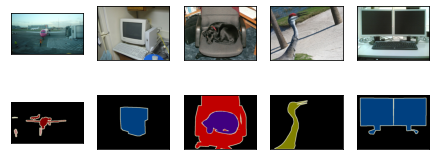

In [4]:
n = 5
imgs = train_features[0:n] + train_labels[0:n]
d2l.show_images(imgs, 2, n);

接下来，我们[**列举RGB颜色值和类名**]。


In [5]:
#@save
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

#@save
VOC_CLASSES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

通过上面定义的两个常量，我们可以方便地[**查找标签中每个像素的类索引**]。
我们定义了`voc_colormap2label`函数来构建从上述RGB颜色值到类别索引的映射，而`voc_label_indices`函数将RGB值映射到在Pascal VOC2012数据集中的类别索引。


In [6]:
#@save
def voc_colormap2label():
    """构建从RGB到VOC类别索引的映射。"""
    colormap2label = np.zeros(256**3)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[(colormap[0] * 256 + colormap[1]) * 256 +
                       colormap[2]] = i
    return colormap2label

#@save
def voc_label_indices(colormap, colormap2label):
    """将VOC标签中的RGB值映射到它们的类别索引。"""
    colormap = colormap.astype(np.int32)
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256 +
           colormap[:, :, 2])
    return colormap2label[idx]

[**例如**]，在第一张样本图像中，飞机头部区域的类别索引为1，而背景索引为0。


In [7]:
y = voc_label_indices(train_labels[0], voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]

(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]]),
 'aeroplane')

### 预处理数据

在之前的实验，例如 :numref:`sec_alexnet`—:numref:`sec_googlenet` 中，我们通过缩放图像使其符合模型的输入形状。
然而在语义分割中，这样做需要将预测的像素类别重新映射回原始尺寸的输入图像。
这样的映射可能不够精确，尤其在不同语义的分割区域。
为了避免这个问题，我们将图像裁剪为固定尺寸，而不是缩放。
具体来说，我们[**使用图像增广中的随机裁剪，裁剪输入图像和标签的相同区域**]。


In [8]:
#@save
def voc_rand_crop(feature, label, height, width):
    """随机裁剪特征和标签图像。"""
    feature, rect = image.random_crop(feature, (width, height))
    label = image.fixed_crop(label, *rect)
    return feature, label

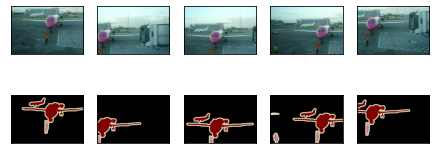

In [9]:
imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

### [**自定义语义分割数据集类**]

我们通过继承高级API提供的`Dataset`类，自定义了一个语义分割数据集类`VOCSegDataset`。
通过实现`__getitem__`函数，我们可以任意访问数据集中索引为`idx`的输入图像及其每个像素的类别索引。
由于数据集中有些图像的尺寸可能小于随机裁剪所指定的输出尺寸，这些样本可以通过自定义的`filter`函数移除掉。
此外，我们还定义了`normalize_image`函数，从而对输入图像的RGB三个通道的值分别做标准化。


In [10]:
#@save
class VOCSegDataset(gluon.data.Dataset):
    """一个用于加载VOC数据集的自定义数据集。"""
    def __init__(self, is_train, crop_size, voc_dir):
        self.rgb_mean = np.array([0.485, 0.456, 0.406])
        self.rgb_std = np.array([0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        self.features = [
            self.normalize_image(feature)
            for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return (img.astype('float32') / 255 - self.rgb_mean) / self.rgb_std

    def filter(self, imgs):
        return [
            img for img in imgs if (img.shape[0] >= self.crop_size[0] and
                                    img.shape[1] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature.transpose(2, 0, 1),
                voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

### [**读取数据集**]

我们通过自定义的`VOCSegDataset`类来分别创建训练集和测试集的实例。
假设我们指定随机裁剪的输出图像的形状为$320\times 480$，
下面我们可以查看训练集和测试集所保留的样本个数。


In [11]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples


read 1078 examples


设批量大小为64，我们定义训练集的迭代器。
打印第一个小批量的形状会发现：与图像分类或目标检测不同，这里的标签是一个三维数组。


In [12]:
batch_size = 64
train_iter = gluon.data.DataLoader(voc_train, batch_size, shuffle=True,
                                   last_batch='discard',
                                   num_workers=d2l.get_dataloader_workers())
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

(64, 3, 320, 480)
(64, 320, 480)


### [**整合所有组件**]

最后，我们定义以下`load_data_voc`函数来下载并读取Pascal VOC2012语义分割数据集。
它返回训练集和测试集的数据迭代器。


In [13]:
#@save
def load_data_voc(batch_size, crop_size):
    """加载VOC语义分割数据集。"""
    voc_dir = d2l.download_extract('voc2012',
                                   os.path.join('VOCdevkit', 'VOC2012'))
    num_workers = d2l.get_dataloader_workers()
    train_iter = gluon.data.DataLoader(
        VOCSegDataset(True, crop_size, voc_dir), batch_size, shuffle=True,
        last_batch='discard', num_workers=num_workers)
    test_iter = gluon.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir), batch_size,
        last_batch='discard', num_workers=num_workers)
    return train_iter, test_iter

## 小结

* 语义分割通过将图像划分为属于不同语义类别的区域，来识别并理解图像中像素级别的内容。
* 语义分割的一个重要的数据集叫做Pascal VOC2012。
* 由于语义分割的输入图像和标签在像素上一一对应，输入图像会被随机裁剪为固定尺寸而不是缩放。

## 练习

1. 如何在自动驾驶车辆和医疗图像诊断中应用语义分割？还能想到其他领域的应用吗？ 
1. 回想一下 :numref:`sec_image_augmentation` 中对数据增强的描述。图像分类中使用的哪种图像增强方法是难以用于语义分割的？


[Discussions](https://discuss.d2l.ai/t/3296)
